In [1]:
%matplotlib inline
%load_ext jupyternotify
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import scipy.integrate
import plotly.graph_objects as go
import time
t1 = time.time()

<IPython.core.display.Javascript object>

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


## Description of the N_STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiencys()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on the variables of the pulse widths, pulse starting times, and the $n$-photon detuning ($\delta$).

* <code>self.robustness(error=0.01)</code>: quantifies the change in efficiency by inducing error (input parameter) to the non optimized variables hence giving a measure of robustness. The aim is to keep this below 0.01 to have a robust STIRAP transfer.

In [33]:
class N_STIRAP():
    def __init__(self,n,Omega,E,T,t,W,Delta,Gamma,nsteps=500):
        self.Omega = np.array(Omega)
        self.E = E
        self.T = T
        self.t = np.array(t)*T
        self.W = np.array(W)*T
        self.n = n
        self.Delta = np.append(0,np.array(Delta) - (0.5j*np.array(Gamma)))
        self.nsteps = nsteps
        
    def _copy(self):
        return N_STIRAP(n=self.n,Omega=self.Omega,E=self.E,T=self.T,t=self.t/self.T,W=self.W/self.T,Delta=self.Delta.real[1:],Gamma=-2*self.Delta.imag[1:],nsteps=self.nsteps)
    
    def _Omega(self,t,i):
        return self.Omega[i]*krotov.shapes.blackman(t, t_start=self.t[i], t_stop=self.t[i]+self.W[i])
    
    def _hamiltonian(self,t,i=None,j=None):
        H0 = np.diag(self.Delta)
        Omegas = np.array([self._Omega(t,i) for i in range(self.n-1)])
        H = 0.5*(np.diagflat(Omegas,k=-1) + np.diagflat(Omegas,k=1))
        if i == None and j == None:
            return H0+H
        return (H0+H)[i,j]
    
    def _final_result(self):
        psi = np.array([int(i==0) for i in range(self.n)])
        tlist = np.linspace(0,self.T,self.nsteps)
        psi_list = [psi]
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi_list[-1])
            psi_list.append(psi)
        eff = (np.absolute(psi[self.n-1])**2)/(np.linalg.norm(psi)**2)
        return np.array(psi_list),tlist,eff
    
    def efficiency(self):
        return self._final_result()[2]
    
    def _neg_eff(self,x):
        self.t = np.array(x[0:self.n-1])
        self.W = np.array(x[self.n-1:-1])
        self.Delta[-1] = x[-1] + self.Delta[-1].imag
        result = self._final_result()
        eff = result[2]
        mini = min(np.absolute(result[0][0])**2 + np.absolute(result[0][-1])**2)
        return mini*np.log(1-eff) + eff*np.log(1-mini)
        
    def plot(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        psiT,t,_ = self._final_result()
        fig, ax = plt.subplots()
        norm = np.linalg.norm(psiT,axis=1)
        for i in range(self.n):
            ax.plot(t, np.absolute(psiT[:,i])**2, label=str(i+1))
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        for i in range(self.n-1):
            pulse = np.array([self._Omega(t,i) for t in tlist])
            plt.plot(tlist, pulse,label=str(i+1)+" to "+str(i+2))
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.append(np.append(self.t,self.W),[self.Delta[-1].real]), args=(), method='Powell', 
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10})
        self.t = np.array(opti.x[0:self.n-1])
        self.W = np.array(opti.x[self.n-1:-1])
        self.delta = opti.x[-1]
        if print_results:
            print("Efficiency: "+str(self.efficiency()))
            print("Starting times (s): "+str(self.t))
            print("Pulse widths (s): "+str(self.W))
            print("n-photon detuning (Hz): "+str(self.delta))
        r = self.robustness()
        if r > 0.01:
            print("Non robust solution reached with slope "+str(r))
        if print_pulse:
            self.plot()
            
    def robustness(self,error=0.01):
        run = self._copy()
        deff = [1 for i in range(2*self.n-1)]
        for i in range(self.n-1):
            run.Omega[i] = (1+error)*self.Omega[i]
            plus = run.efficiency()
            run.Omega[i] = (1-error)*self.Omega[i]
            minus = run.efficiency()
            deff[2*i] = (plus - minus)/(2*error)
            run = self._copy()
            run.Delta[i+1] = (1+error)*self.Delta[i+1]
            plus = run.efficiency()
            run.Delta[i+1] = (1-error)*self.Delta[i+1]
            minus = run.efficiency()
            deff[2*i + 1] = (plus - minus)/(2*error)
            run = self._copy()
        run.T = (1+error)*self.T
        plus = run.efficiency()
        run.T = (1-error)*self.T
        minus = run.efficiency()
        deff[-1] = (plus - minus)/(2*error)
        deff = np.array(deff)
        return np.dot(deff,deff)

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 10 $\mu s$. The single photon detuning is $\Delta = 0.1$ GHz and there is two photon resonance.

In [3]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)

Efficiency = 0.9999999002465461
Robustness = 8.221426328506352e-07


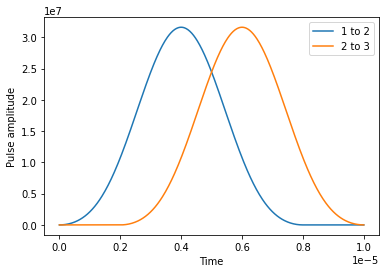

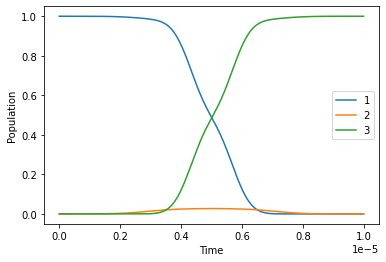

In [9]:
try_1 = N_STIRAP(n=3,Omega=[31.6*10**6,31.6*10**6],E=[0,hfs,F_3],T=10**(-5),t=[0,0.2],W=[0.8,0.8],Delta=[10**8,0],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

Efficiency = 0.9947034894418675
Robustness = 0.060590334332165235


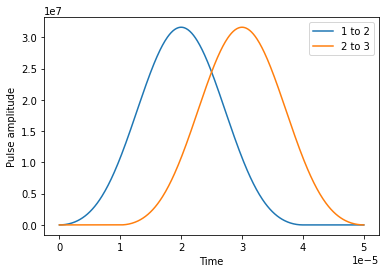

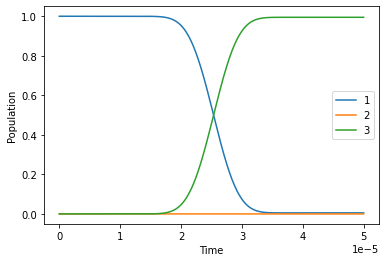

In [46]:
try_1 = N_STIRAP(n=3,Omega=[31.6*10**6,31.6*10**6],E=[0,hfs,F_3],T=0.5*10**(-4),t=[0,0.2],W=[0.8,0.8],Delta=[10**9,0],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

### Example 2
Below is the simulation for a very basic case of 4-level STIRAP with a fairly efficient guess

Efficiency = 0.9983610697752564
Robustness = 0.3870229152088564


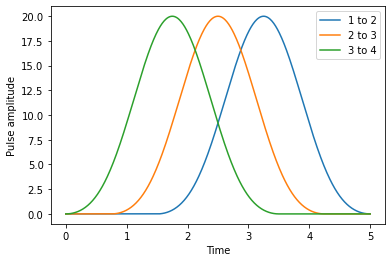

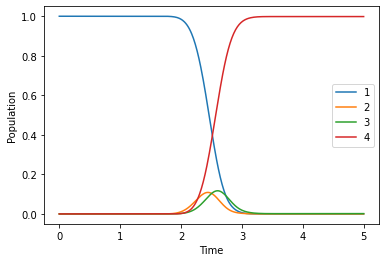

In [13]:
try_2 = N_STIRAP(n=4,Omega=[20,20,20],E=[0,5,10,15],T=5,t=[0.3,0.15,0],W=[0.7,0.7,0.7],Delta=[0,0,0],Gamma=[0,0,0],nsteps=500)
print("Efficiency = "+str(try_2.efficiency()))
print("Robustness = "+str(try_2.robustness()))
try_2.plot()

### Example 3

Efficiency = 4.496962069361909e-16
Robustness = 4.9304913336872e-25


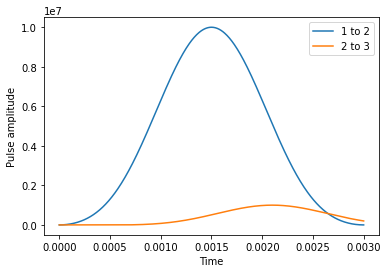

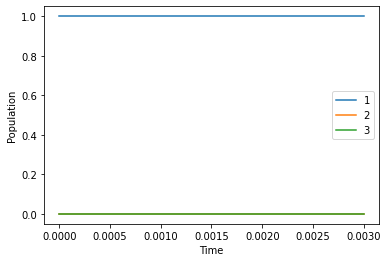

In [47]:
try_3 = N_STIRAP(n=3,Omega=[10*10**6,10**6],E=[0,hfs,F_3],T=3*10**(-3),t=[0,0.2],W=[1,1],Delta=[10**9,2.18*10**6],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_3.efficiency()))
print("Robustness = "+str(try_3.robustness()))
try_3.plot()

## Description of the cavity_STIRAP class

In the below cell is the definition for <code>class cavity_STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiencys()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance being the final population in state 4.

* <code>self.plot(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on the variables of the pulse widths, pulse starting times, and the $n$-photon detuning ($\delta$).

* <code>self.robustness(error=0.01)</code>: quantifies the change in efficiency by inducing error (input parameter) to the non optimized variables hence giving a measure of robustness. The aim is to keep this below 0.01 to have a robust STIRAP transfer.

In [54]:
class cavity_STIRAP():
    def __init__(self,Omega,E,T,t,W,Delta,Gamma,kappa,nsteps=500):
        self.Omega = np.array(Omega)
        self.E = E
        self.T = T
        self.t = np.array(t)*T
        self.W = np.array(W)*T
        self.n = 4
        self.Delta = np.append(0,np.array(Delta) - (0.5j*np.array(Gamma)))
        self.kappa = kappa
        self.nsteps = nsteps
        
    def _copy(self):
        return cavity_STIRAP(Omega=self.Omega,E=self.E,T=self.T,t=self.t/self.T,W=self.W/self.T,Delta=self.Delta.real[1:],Gamma=-2*self.Delta.imag[1:],kappa=self.kappa,nsteps=self.nsteps)
    
    def _Omega12(self,t,args=None):
        return self.Omega[0]*krotov.shapes.blackman(t, t_start=self.t[0], t_stop=self.t[0]+self.W[0])
    
    def _Omega23(self,t,args=None):
        return self.Omega[1]*krotov.shapes.blackman(t, t_start=self.t[1], t_stop=self.t[1]+self.W[1])
    
    def _cavity_coupling(self,t,args=None):
        return self.Omega[-1]
    
    def _hamiltonian(self):
        H0 = tensor(Qobj(np.diag(self.Delta)),qeye(4))
        H_Omega12 = tensor(Qobj([[0.0,0.5,0.0,0.0],[0.5,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0]]),qeye(4))
        H_Omega23 = tensor(Qobj([[0.0,0.0,0.0,0.0],[0.0,0.0,0.5,0.0],[0.0,0.5,0.0,0.0],[0.0,0.0,0.0,0.0]]),qeye(4))
        Hg = tensor(Qobj([[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.1,0.0]]),create(4)) + tensor(Qobj([[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.1],[0.0,0.0,0.0,0.0]]),destroy(4)) 
        return [H0,[H_Omega12,self._Omega12],[H_Omega23,self._Omega23],[Hg,self._cavity_coupling]]
    
    def _final_result(self):
        psi0 = tensor(fock(self.n,0),fock(4,1))
        kets = [Qobj(np.array([float(i is j) for j in range(self.n)])) for i in range(self.n)]
        a = tensor(qeye(self.n),destroy(4))
        e_op_list = [tensor(ket2dm(ket),qeye(4)) for ket in kets] + [a.dag() * a]
        tlist = np.linspace(0,self.T,self.nsteps)
        H = self._hamiltonian()
        c_op_list = [np.sqrt(self.kappa)*a]
        output = mesolve(H, psi0, tlist, c_op_list, e_op_list)
        eff = output.expect[3][-1]
        return output,eff
    
    def efficiency(self):
        return self._final_result()[1]
    
    def _neg_eff(self,x):
        self.t = np.array(x[0:2])
        self.W = np.array(x[2:-1])
        self.Delta[-1] = x[-1] + self.Delta[-1].imag
        result = self._final_result()
        eff = result[1]
        return np.log(1-eff)
        
    def plot(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        result,_ = self._final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.plot(result.times, result.expect[3], label='4')
        ax.plot(result.times, result.expect[4], label='cavity')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        pulse = np.array([self._Omega12(t) for t in tlist])
        plt.plot(tlist, pulse,label="1 to 2")
        pulse = np.array([self._Omega23(t) for t in tlist])
        plt.plot(tlist, pulse,label="2 to 3")
        pulse = np.array([2*self._cavity_coupling(t) for t in tlist])
        plt.plot(tlist, pulse,label="2g(t)")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.append(np.append(self.t,self.W),[self.Delta[-1].real,self.kappa]), args=(), method='Powell', 
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10})
        if print_results:
            print(opti)
        self.t = np.array(opti.x[0:2])
        self.W = np.array(opti.x[2:-1])
        self.delta = opti.x[-1]
        r = self.robustness()
        if r > 0.01:
            print("Non robust solution reached")
        if print_pulse:
            self.plot_for_guess()
            
    def robustness(self,error=0.01):
        run = self._copy()
        deff = [1 for i in range(2*self.n-1)]
        for i in range(self.n-1):
            run.Omega[i] = (1+error)*self.Omega[i]
            plus = run.efficiency()
            run.Omega[i] = (1-error)*self.Omega[i]
            minus = run.efficiency()
            deff[2*i] = (plus - minus)/(2*error)
            run = self._copy()
            run.Delta[i+1] = (1+error)*self.Delta[i+1]
            plus = run.efficiency()
            run.Delta[i+1] = (1-error)*self.Delta[i+1]
            minus = run.efficiency()
            deff[2*i + 1] = (plus - minus)/(2*error)
            run = self._copy()
        run.T = (1+error)*self.T
        plus = run.efficiency()
        run.T = (1-error)*self.T
        minus = run.efficiency()
        deff[-1] = (plus - minus)/(2*error)
        deff = np.array(deff)
        return np.dot(deff,deff)

### Example 4

Efficiency = 0.9631451541234755
Robustness = 0.21583988554253405


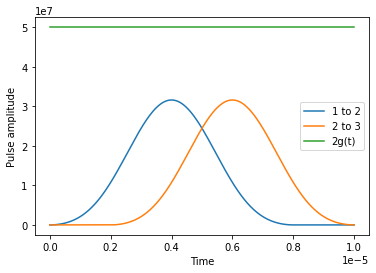

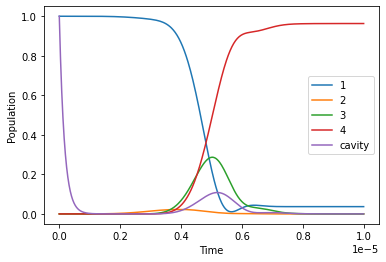

In [53]:
try_4 = cavity_STIRAP(Omega=[31.6*10**6,31.6*10**6,2.5*10**7],E=[0,hfs,F_3,hfs],T=10**(-5),t=[0,0.2],W=[0.8,0.8],Delta=[10**8,0,0],Gamma=[0,0,0],kappa=6*10**6,nsteps=500)
print("Efficiency = "+str(try_4.efficiency()))
print("Robustness = "+str(try_4.robustness()))
try_4.plot()